<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера:</b> 
    
Елена, привет! Меня зовут Влада. Проект выполнен на очень высоком уровне, но есть несколько мелких замечаний. Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='blue'>синий — «хорошо, но можно лучше (исправлять необязательно)»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###». Пожалуйста, не удаляй мои комментарии, они мне нужны при повторной проверке.

</div>

Влада, привет! Спасибо за ревью и полезные дополнения! <br> Перед ячейками со скорректированным кодом сделала пометку <font  color='purple'> !Доработано </font> 

# Отток клиентов

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [0. Подгрузка библиотек и самописные функции](#0.)
* [1. Подготовка данных](#1.)
* [2. Обучение модели без учёта дисбаланса](#2.)
* [3. Борьба с дисбалансом](#3.)
* [4. Тестирование модели](#4.)
* [5. Проверка модели на адекватность](#5.)
* [Вывод](#6.)


# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Краткий план работы:

* Загрузите и подготовьте данные. Поясните порядок действий.
* Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
* Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
* Проведите финальное тестирование.

## Описание данных
**Признаки**
* 		RowNumber — индекс строки в данных
* 		CustomerId — уникальный идентификатор клиента
* 		Surname — фамилия
* 		CreditScore — кредитный рейтинг
* 		Geography — страна проживания
* 		Gender — пол
* 		Age — возраст
* 		Tenure — количество недвижимости у клиента
* 		Balance — баланс на счёте
* 		NumOfProducts — количество продуктов банка, используемых клиентом
* 		HasCrCard — наличие кредитной карты
* 		IsActiveMember — активность клиента
* 		EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* 		Exited — факт ухода клиента

<a name="0."></a><br/>
<font size="6"><b>0. Подгрузка библиотек и самописные функции</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import numpy as np
import pandas as pd

import joblib
import time
import warnings

from plotly.subplots import make_subplots

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics  import f1_score
from sklearn.metrics  import precision_score
from sklearn.metrics  import recall_score
from sklearn.metrics  import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import r2_score 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from termcolor import colored

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import seaborn as sns

from scipy import stats as st

In [2]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

#Убираем ворнинги
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#4 входных параметра

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        

def print_basic_info(base, info, head, describe):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())

In [4]:
#__Функция ft_namecount__, для вывода названия переменной, частотной нормированной таблицы и описания переменной.

#5 входных параметров:

#* *base* - название базы данных
#* *index* - название переменной в базе
#* *table* - 1: вывод частотной нормированной таблицы, 0: не вывод
#* *sort* - 1: сортировка таблицы по лейблам переменной, 0: не сортировка
#* *describe* - 1: вывод описания переменной, 0: не вывод

def ft_name_count (base, name , table, sort, describe):
    print(bold(), colored(name,'blue') , bold_end(), "\n")
    if table != 0:
        s = (base[name].value_counts(normalize=True))
        if sort != 0:
            s.sort_index(inplace=True)
        print(s)
    if describe != 0:
        print(base[name].describe())

In [5]:
#Сделаем функцию ___ft_hist_comp(base, name, cross, title,labelx, labely)___, для вывода графика боксплот в разрезе

#6 входных параметров

#* *base* - название базы данных
#* *name* - имя переменной в базе
#* *cross* - имя переменной, в разрезе которой смотрим
#* *title* - название таблицы
#* *labelx* - лейбл X
#* *labely* - лейбл Y

def ft_hist_comp(base, name, cross,title,labelx, labely):
    for i in base[cross].unique():
        base[base[cross] == i][name].hist(bins = 50, label = 
                                              str(i), alpha=0.7, density=True)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title, fontsize=15) 
    plt.legend()
    plt.show()

<a name="1."></a><br/>
<font size="6"><b>1. Подготовка данных</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

**Открываем**

In [6]:
#Работаю локально, онлайн путь в хабе немного другой ('/datasets/Churn.csv')
df_churn = pd.read_csv('datasets/Churn.csv', sep=',',decimal='.', index_col = 'RowNumber')

**Смотрим информацию**

In [7]:
#Инфо
print_basic_info(df_churn,1,5,0)


  info  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB
None

  head 


CustomerId   Surname  CreditScore Geography  Gender  Age  \
RowNumber                                                             
1            15634602  Hargrave          619    France  Female   42   
2            15647311      Hill          608     Spain  Female   41   
3            15619304      Onio          502    France  Female   42   
4            15701354      Boni          699    France  Female   39   
5            15737888  Mitchell          850     Spain  Female   43   

              Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
RowNumber                                                                   
1               2.00       0.00              1          1               1   
2               1.00   83807.86              1          0               1   
3               8.00  159660.80              3          1               0   
4               1.00       0.00              2          0               0   
5               2.00  125510.82              1          1               1   

           EstimatedSalary  Exited  
RowNumber                           
1                101348.88       1  
2                112542.58       0  
3                113931.57       1  
4                 93826.63       0  
5                 79084.10       0

In [8]:
#описание переменных
print_basic_info(df_churn,0,0,1)


  describe  


  CustomerId  
 count      10000.00
mean    15690940.57
std        71936.19
min     15565701.00
25%     15628528.25
50%     15690738.00
75%     15753233.75
max     15815690.00
Name: CustomerId, dtype: float64

  Surname  
 count     10000
unique     2932
top       Smith
freq         32
Name: Surname, dtype: object

  CreditScore  
 count     10000.00
mean        650.53
std          96.65
min         350.00
25%         584.00
50%         652.00
75%         718.00
max         850.00
Name: CreditScore, dtype: float64

  Geography  
 count      10000
unique         3
top       France
freq        5014
Name: Geography, dtype: object

  Gender  
 count     10000
unique        2
top        Male
freq       5457
Name: Gender, dtype: object

  Age  
 count     10000.00
mean         38.92
std          10.49
min          18.00
25%          32.00
50%          37.00
75%          44.00
max          92.00
Name: Age, dtype: float64

  Tenure  
 count      9091.00
mean          5.00
std  

#### Вывод:

База состоит из 10 тыс. кейсов. <br>

Все заполненные, кроме столбца  Tenure (количество недвижимости у клиента)

* Для анализа и построения нам точно не потребуется столбцы с Surname и CustomerId. Это данные идентификации клиентов, а не их поведения. Сразу их удалим.

* Колонки с большой буквы. Оставим в таком формате

* заполнить Tenure (количество недвижимости у клиента) проверить связи пропусков с другими переменными и предположительно заполнить на основе возраста, пола и зарплаты. Вероятно отсутствие данных связано с  недостатком информации, возможно поле не было заполнено работниками банка, возможно в конкретных анкетах клиента этот вопрос не уточнялся.

* в столбце EstimatedSalary - есть экстремально минимальные значения (например 11.58). Необходимо проверить сколько таких значений. Если много - с ними надо что -то делать. Если совсем мало - можно оставить. Стоит ли его включать в модель? Скорее да.

Необходимо перевести в позиционный формат для работы модели
* Geography
* Gender


**Exited** - Всего 20% базы - те клиенты, которые ушли. Этих данных может не хватить, чтобы модель поняла особенности данных клиентов. 
Поэтому возможно нам потребуется буситровать эту часть выборки, при обучении модели.

<div class="alert alert-block alert-success">
Отлично, все верно!
</div>

#### Отбросим ненужные столбцы

In [9]:
df_churn.drop(['CustomerId','Surname'], axis=1, inplace = True)   

<div class="alert alert-block alert-success">
Да, эти столбцы не информативны.
</div>

#### Пропущенные значения (tenure)

In [10]:
ft_name_count(df_churn,'Tenure',1,1,0)

 Tenure  

 0.00         0.04
 1.00         0.10
 2.00         0.10
 3.00         0.10
 4.00         0.10
 5.00         0.10
 6.00         0.10
 7.00         0.10
 8.00         0.10
 9.00         0.10
10.00         0.05
Name: Tenure, dtype: float64


Данные распределены достаточно равномерно. Нет подавляющей группы.

Посмотрим корреляцию. Есть ли высокая

<font  color='purple'> !Доработано </font> 

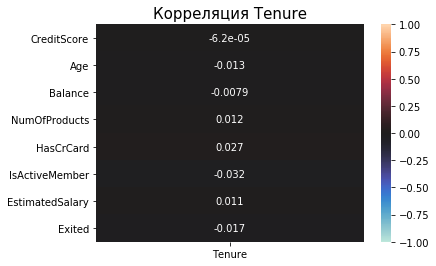

In [11]:
corr = df_churn.corr()
y = ['Tenure']
x = []
for i in corr.columns:
    if (corr.loc[i,'Tenure'] < 1 ):
        x.append(i)

corr = corr.loc[x,y]

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.index,
            center=0, annot=True, vmin=-1, vmax=1 )
plt.title("Корреляция Tenure", fontsize=15)
plt.show()

Таких нет. Хорошо

Посмотрим на профили c пропусками и без и  стравним

<div class="alert alert-block alert-info">
Можно было вывести всю корреляционную матрицу, чтобы увидеть общую картину.
</div>

In [12]:
#с пропусками
print_basic_info(df_churn[df_churn['Tenure'].isnull() == True],0,0,1)


  describe  


  CreditScore  
 count       909.00
mean        648.45
std          99.08
min         359.00
25%         580.00
50%         647.00
75%         718.00
max         850.00
Name: CreditScore, dtype: float64

  Geography  
 count        909
unique         3
top       France
freq         464
Name: Geography, dtype: object

  Gender  
 count      909
unique       2
top       Male
freq       483
Name: Gender, dtype: object

  Age  
 count       909.00
mean         38.65
std           9.79
min          18.00
25%          32.00
50%          37.00
75%          43.00
max          92.00
Name: Age, dtype: float64

  Tenure  
 count         0.00
mean           nan
std            nan
min            nan
25%            nan
50%            nan
75%            nan
max            nan
Name: Tenure, dtype: float64

  Balance  
 count       909.00
mean      76117.34
std       63105.69
min           0.00
25%           0.00
50%       96674.55
75%      128554.98
max      206663.75
Name: Balance, dt

In [13]:
#без
print_basic_info(df_churn[df_churn['Tenure'].isnull() == False],0,0,1)


  describe  


  CreditScore  
 count      9091.00
mean        650.74
std          96.41
min         350.00
25%         584.00
50%         652.00
75%         717.00
max         850.00
Name: CreditScore, dtype: float64

  Geography  
 count       9091
unique         3
top       France
freq        4550
Name: Geography, dtype: object

  Gender  
 count     9091
unique       2
top       Male
freq      4974
Name: Gender, dtype: object

  Age  
 count      9091.00
mean         38.95
std          10.56
min          18.00
25%          32.00
50%          37.00
75%          44.00
max          92.00
Name: Age, dtype: float64

  Tenure  
 count      9091.00
mean          5.00
std           2.89
min           0.00
25%           2.00
50%           5.00
75%           7.00
max          10.00
Name: Tenure, dtype: float64

  Balance  
 count      9091.00
mean      76522.74
std       62329.53
min           0.00
25%           0.00
50%       97318.25
75%      127561.89
max      250898.09
Name: Balance, dt

Профили очень схожие. Будем заполнять медианой, на основе пола и возраста.

In [14]:
#Делаем переменную
df_churn['IsTenureFilled'] = df_churn['Tenure'].isnull() == True

print("Пропусков", df_churn[df_churn['Tenure'].isnull() == True]['Age'].count())

Пропусков 909


Заполняем. Проверяем, что не перекосили.

In [15]:
fig = go.Figure()
fig.add_trace(go.Box(x=df_churn['Tenure'], y=df_churn['Exited'], name='smart', marker_color='#3D9970'))
fig.update_layout(xaxis=dict(title='Exited ', zeroline=False), boxmode='group',
                  title = "CreditScore by Exited, до заполнения",height=320)
fig.update_traces(orientation='h') 
fig.show()

<font  color='purple'> !Доработано </font> 

In [16]:
#запоним единой медианой

dict_tenure = df_churn[df_churn['Tenure'].isnull() == False]['Tenure'].median()

def tenure_fill(x):
    Tenure = x['Tenure']
    if (pd.isnull(Tenure)):
        Tenure = dict_tenure
        return Tenure
    return Tenure

In [17]:
#применяем
df_churn['Tenure'] = df_churn.apply(tenure_fill, axis=1)

#проверяем
print("Пропусков", df_churn[df_churn['Tenure'].isnull() == True]['Age'].count())
df_churn[df_churn['Tenure'].isnull() == True]

Пропусков 0


Empty DataFrame
Columns: [CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, IsTenureFilled]
Index: []

Проверим перекос

In [18]:
fig = go.Figure()
fig.add_trace(go.Box(x=df_churn['Tenure'], y=df_churn['Exited'], name='smart', marker_color='#3D9970'))
fig.update_layout(xaxis=dict(title='Exited ', zeroline=False), boxmode='group',
                  title = "CreditScore by Exited,после заполнения медианой",height=320)
fig.update_traces(orientation='h') 
fig.show()

<font  color='purple'> !Доработано </font> 

Перекосили. Значит заполним 0, возможно это позволит избежать перекоса

In [19]:
df_churn['Tenure'] = df_churn['Tenure'].where(df_churn['IsTenureFilled'] != True, 0)

ft_name_count(df_churn,'Tenure',1,1,0)

 Tenure  

 0.00         0.13
 1.00         0.10
 2.00         0.10
 3.00         0.09
 4.00         0.09
 5.00         0.09
 6.00         0.09
 7.00         0.09
 8.00         0.09
 9.00         0.09
10.00         0.04
Name: Tenure, dtype: float64


In [20]:
fig = go.Figure()
fig.add_trace(go.Box(x=df_churn['Tenure'], y=df_churn['Exited'], name='smart', marker_color='#3D9970'))
fig.update_layout(xaxis=dict(title='Exited ', zeroline=False), boxmode='group',
                  title = "CreditScore by Exited,после заполнения 0",height=320)
fig.update_traces(orientation='h') 
fig.show()

<div class="alert alert-block alert-danger">
Так как признак Tenure является количественным (не категориальным), то заполнять пропуски новым значением некорректно. Стоит заполнить либо медианным значением, либо нулем (подразумевая, что пропуски связаны с 0 значениями), либо удалить их.
</div>

Оставляем так

In [21]:
df_churn.drop(['IsTenureFilled'], axis=1, inplace = True)   

**Посмотрим сколько странных значений в EstimatedSalary** 

Сколько менее 500? 23


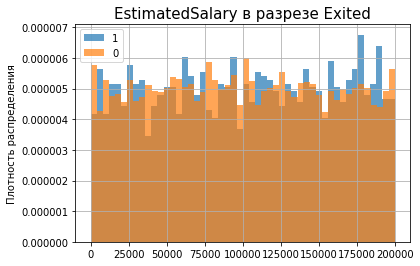

In [22]:
print("Сколько менее 500?",df_churn.query('EstimatedSalary < 500').EstimatedSalary.count())

ft_hist_comp(df_churn, name = 'EstimatedSalary', cross = 'Exited',
             title ='EstimatedSalary в разрезе Exited', labely = 'Плотность распределения', labelx = '')

С очень маленькой зарплатой совсем немного. Оставляем как есть

**Посмотрим внимательней на оставшиеся переменные.** 
* CreditScore

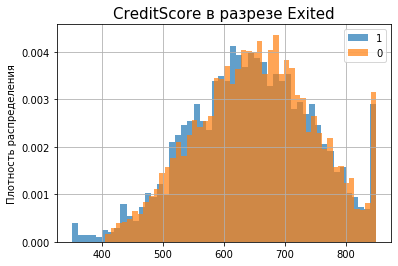

In [23]:
ft_hist_comp(df_churn, name = 'CreditScore', cross = 'Exited',
             title ='CreditScore в разрезе Exited', labely = 'Плотность распределения', labelx = '')

<div class="alert alert-block alert-success">
Графики наглядные. Молодец, что нормируешь распределения.
</div>

<div class="alert alert-block alert-info">
Только по вертикальной оси не «процент от кейсов», а «плотность распределения». Так как при отрисовке графиков ты задаешь density=True, то гистограммы нормируются так, чтобы суммарная площадь столбиков была равна 1.
</div>

Профили схожие, однако среди ушедших оценки чуть ниже и есть группа людей с экстремально низким показателем. 

Оставляем переменную как есть и обязательно берем в модель. 

Также показатель в будущем возможно потребуется отнормировать, так как показатели сильно варьируется.

* Age

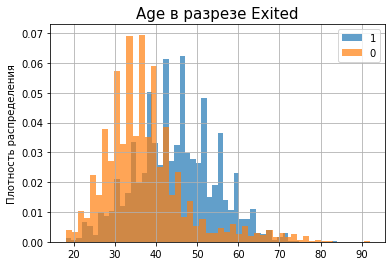

In [24]:
ft_hist_comp(df_churn, name = 'Age', cross = 'Exited',
            title ='Age в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Профили разные!Ушедшие помоложе.
Оставляем переменную как есть и обязательно берем в модель. 

* Balance

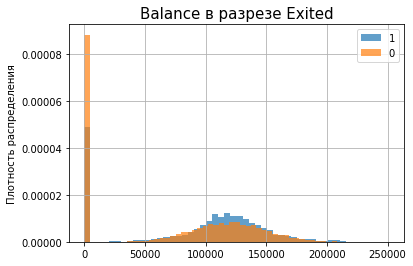

In [25]:
ft_hist_comp(df_churn, name = 'Balance', cross = 'Exited',
       title ='Balance в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Интересно, что есть группа людей с нулевым балансом. В Анализ берем. 

* NumOfProducts

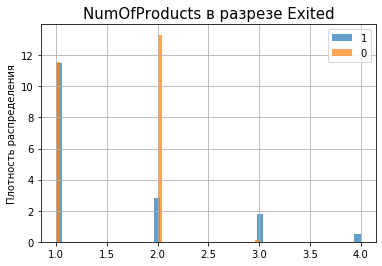

In [26]:
ft_hist_comp(df_churn, name = 'NumOfProducts', cross = 'Exited',
       title ='NumOfProducts в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Ушедшие пользовались большим количеством продуктов. Берем в анализ

* HasCrCard

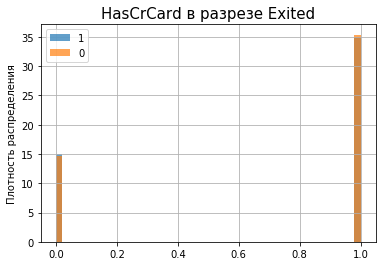

In [27]:
ft_hist_comp(df_churn, name = 'HasCrCard', cross = 'Exited',
       title ='HasCrCard в разрезе Exited', labely = 'Плотность распределения', labelx = '')

<font  color='purple'> !Доработано </font> 

Профили схожие. Однако в модель возьмем т.к. признак не помешает модели, а может и  помочь  в связке с другими признаками.

<div class="alert alert-block alert-info">
Признак может быть малоинформативным сам по себе, но значимым в связке с другим признаком. Лучший вариант – построить модели с данным признаком и без него и сравнить результаты.
</div>

* IsActiveMember

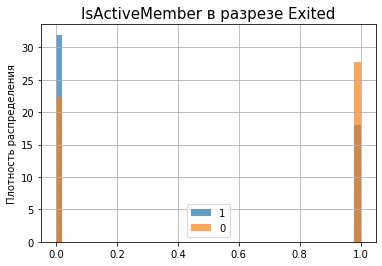

In [28]:
ft_hist_comp(df_churn, name = 'IsActiveMember', cross = 'Exited',
       title ='IsActiveMember в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Профили различаются. Для построения возьмем.

* Geography

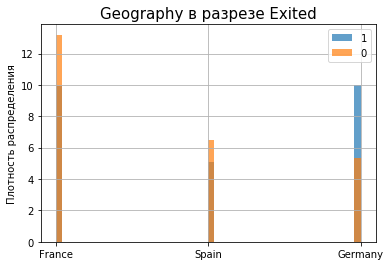

In [29]:
ft_hist_comp(df_churn, name = 'Geography', cross = 'Exited',
       title ='Geography в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Профили различаются. Для построения возьмем.

* Gender

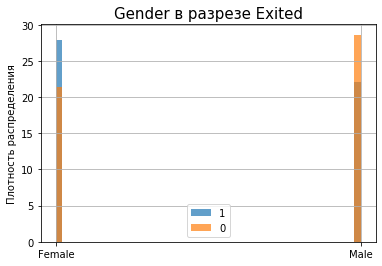

In [30]:
ft_hist_comp(df_churn, name = 'Gender', cross = 'Exited',
       title ='Gender в разрезе Exited', labely = 'Плотность распределения', labelx = '')

Профили различаются. Для построения возьмем.

#### Переведем в позиционные значения

In [31]:
df_churn_ohe = pd.get_dummies(df_churn, drop_first=True)
df_churn_ohe
display(df_churn_ohe.head())

CreditScore  Age     Tenure    Balance  NumOfProducts  HasCrCard  \
RowNumber                                                                     
1                  619   42       2.00       0.00              1          1   
2                  608   41       1.00   83807.86              1          0   
3                  502   42       8.00  159660.80              3          1   
4                  699   39       1.00       0.00              2          0   
5                  850   43       2.00  125510.82              1          1   

           IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
RowNumber                                                               
1                       1        101348.88       1                  0   
2                       1        112542.58       0                  0   
3                       0        113931.57       1                  0   
4                       0         93826.63       0                  0   
5                       1         79084.10       0                  0   

           Geography_Spain  Gender_Male  
RowNumber                                
1                        0            0  
2                        1            0  
3                        0            0  
4                        0            0  
5                        1            0

<div class="alert alert-block alert-success">
OHE-кодирование проведено корректно, избыточные столбцы следует удалять (drop_first=True).
</div>

Смотрим чтобы небыло прямой зависимости между переменными.


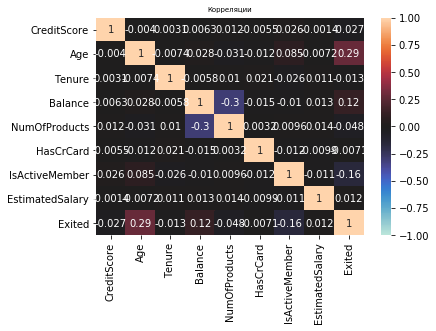

In [32]:
corr = df_churn.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.index,
            center=0, annot=True, vmin=-1, vmax=1 )
plt.title("Корреляции", fontsize=7)
plt.show()

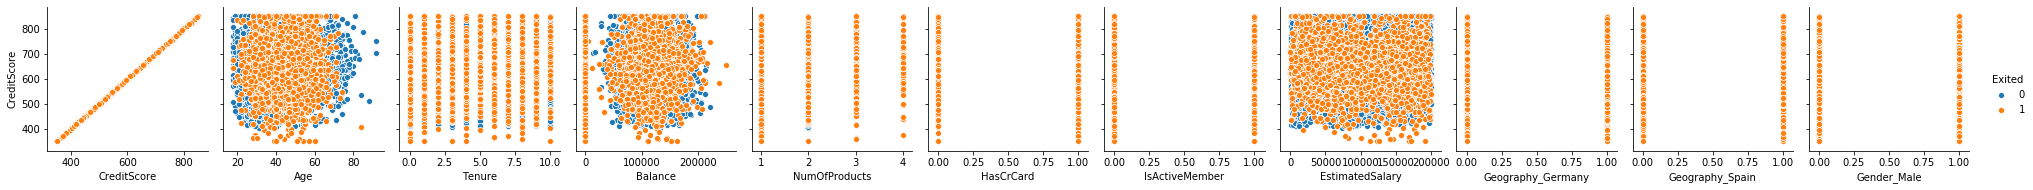

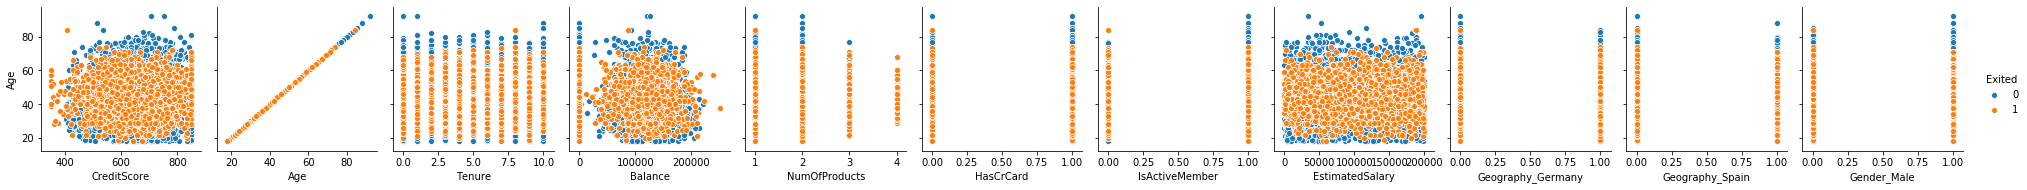

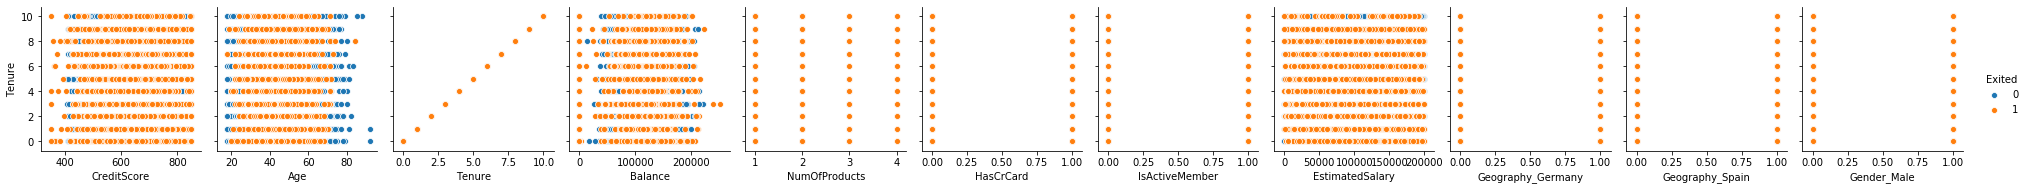

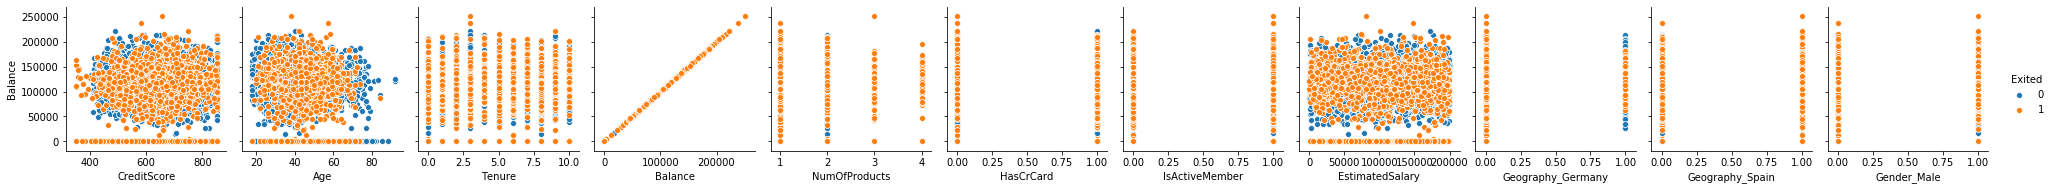

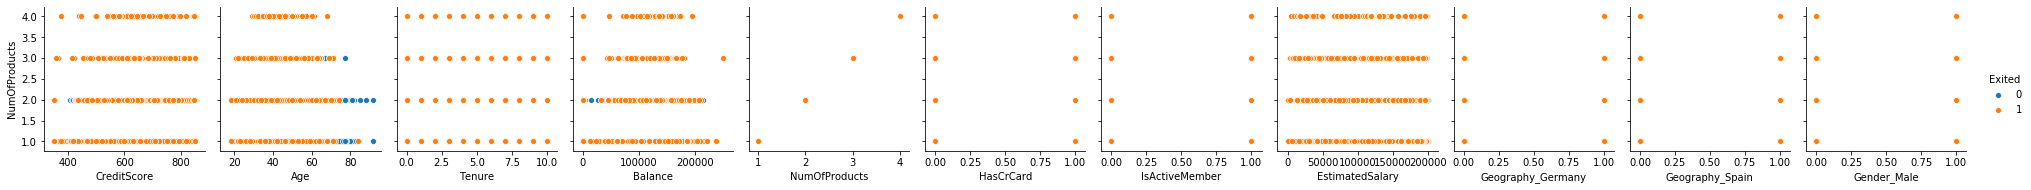

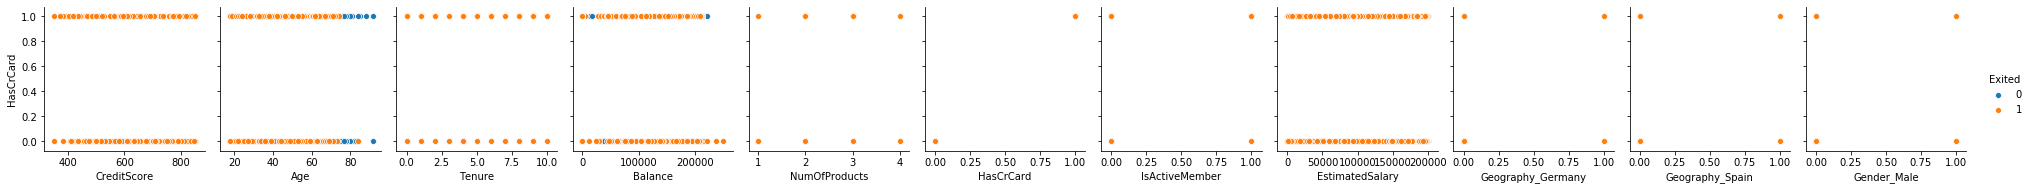

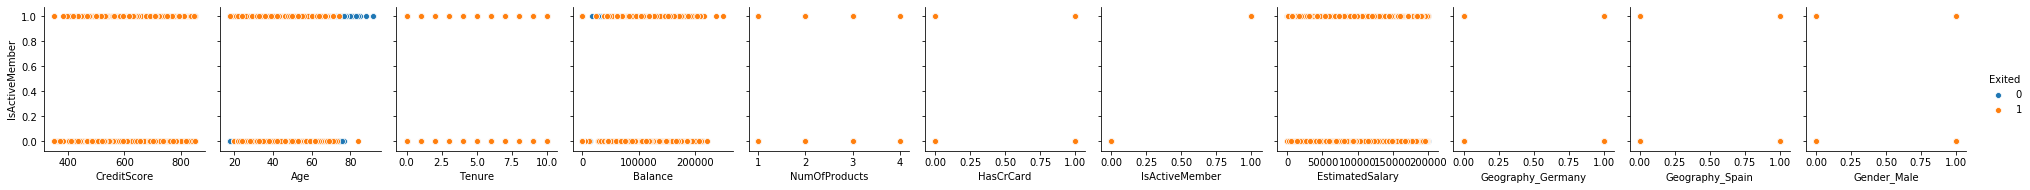

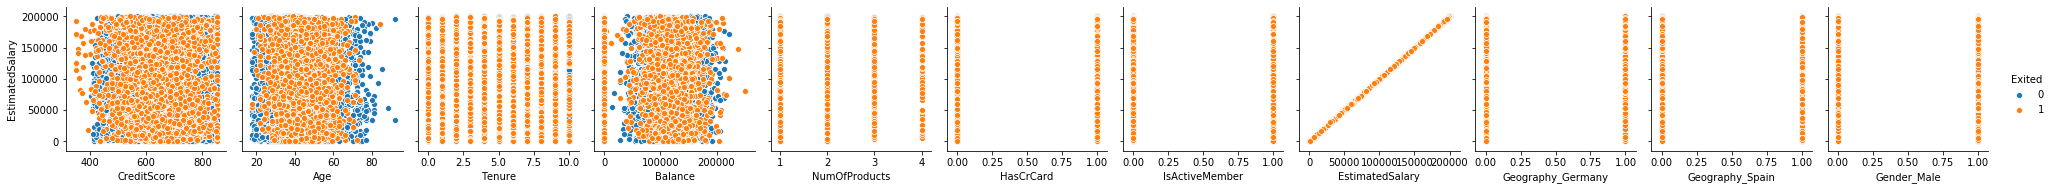

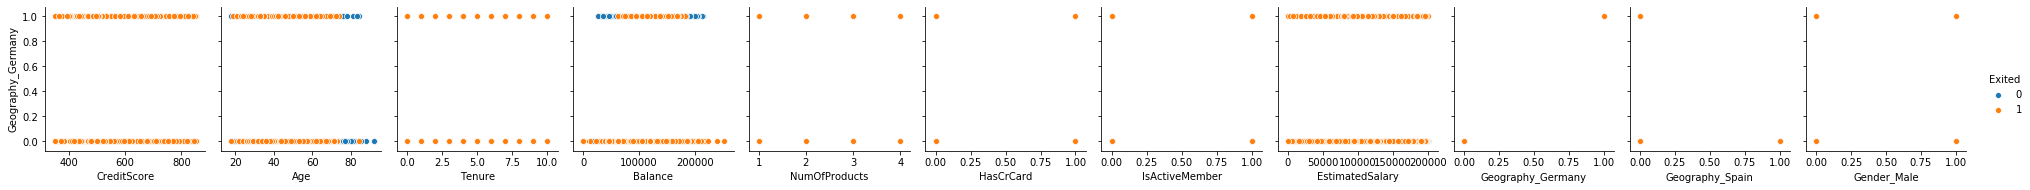

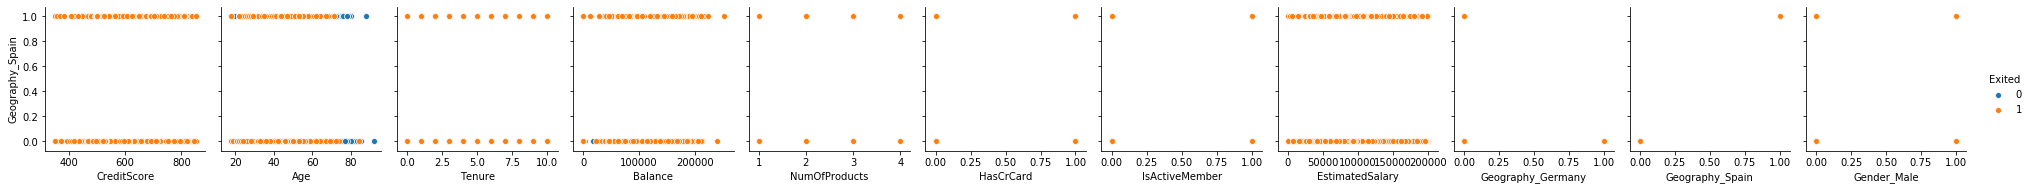

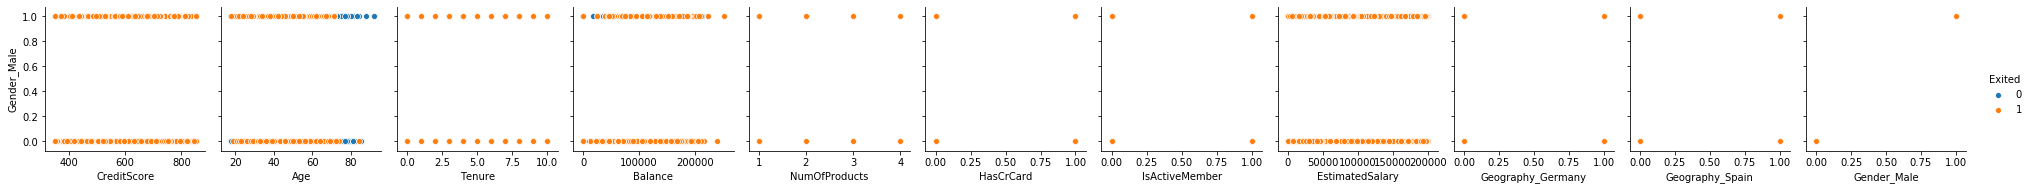

In [33]:
#сделаем кросс табличку
l_col = []
for i in df_churn_ohe.columns:
    if i != 'Exited':
        l_col.append(i)

for i in l_col:
    sns.pairplot(df_churn_ohe, x_vars = l_col, y_vars=i, hue = 'Exited')

plt.show()

Сильной корреляции нет. Оставляем все переменные для модели.

<div class="alert alert-block alert-success">
Отлично, все наглядно, молодец!
</div>

#### Разабьем данные на выборки

In [34]:
features = df_churn_ohe.drop(['Exited'], axis=1)
target = df_churn_ohe['Exited']

#разбиваем на train и остальное. стратифицируем
features_train, features_other, target_train, target_other = train_test_split(features, target , test_size=0.40, 
                                                                              random_state=515093, stratify = target)

#разбиваем на тест и валид. стратифицируем
features_valid, features_test,target_valid,  target_test = train_test_split(features_other, target_other,
                                                                            test_size=0.50, random_state=515093,
                                                                           stratify = target_other)



print("all sample",features.shape)
print("features_train sample",features_train.shape)
print("target_train sample",target_train.shape)
print("features_valid sample",features_valid.shape)
print("target_valid sample",target_valid.shape)
print("features_test sample",features_test.shape)
print("target_test sample",target_test.shape)

all sample (10000, 11)
features_train sample (6000, 11)
target_train sample (6000,)
features_valid sample (2000, 11)
target_valid sample (2000,)
features_test sample (2000, 11)
target_test sample (2000,)


<div class="alert alert-block alert-success">
Деление выборки на части проведено корректно. Здорово, что задаешь параметр stratify, это важно при несбалансированных классах.
</div>

In [35]:
# Проверим что равномерно разбилось. Насколько отличаются средние?
print("Exited:", round(target_train.mean(),4), "vs", round(target_valid.mean(),4) ,"vs", round(target_test.mean(),4))

Exited: 0.2037 vs 0.204 vs 0.2035


На первый взгляд разбилось достаточно равномерно.

**Только 0.2 ушедших. <br>
В исследовании вероятно будет необходимо сделать буст, для того чтобы модель имела больше кейсов с классом 1 для работы.**

<div class="alert alert-block alert-success">
Да, наблюдается дисбаланс.
</div>

In [36]:
#Масштабируем признаки
numeric = ['CreditScore','Age','Balance','EstimatedSalary','Tenure','NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())

CreditScore        Age     Tenure    Balance  NumOfProducts  \
RowNumber                                                                
5643              1.36       0.20      -0.17      -1.22          -0.91   
2448             -0.31      -1.24      -0.81      -0.01          -0.91   
1391              0.02      -1.14       1.43      -1.22           0.80   
1703              0.36      -1.62       0.15      -1.22           0.80   
9448              0.70       0.20      -1.13      -1.22           0.80   

           HasCrCard  IsActiveMember  EstimatedSalary  Geography_Germany  \
RowNumber                                                                  
5643               1               0             0.57                  0   
2448               0               1            -0.98                  0   
1391               1               0            -0.07                  0   
1703               1               0             1.02                  0   
9448               0               1            -1.27                  0   

           Geography_Spain  Gender_Male  
RowNumber                                
5643                     1            0  
2448                     0            1  
1391                     0            0  
1703                     1            1  
9448                     0            0

<div class="alert alert-block alert-success">
Масштабирование проведено корректно. Scaler следует настраивать (fit) только по обучающей выборке.
</div>

#### Вывод:

В рамках обработки данных:

* Отбросили ненужные столбцы ('CustomerId','Surname', 'HasCrCard')
* Заполнили пропуски Tenure значениями -1
* Разбили данные на обучающую, валидационую и тестовую.
* Масштабировали количественные перемеренные.



<div class="alert alert-block alert-success">
Прекрасно, данные готовы к обучению.
</div>

<a name="2."></a><br/>
<font size="6"><b>2. Обучение модели без учёта дисбаланса</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

### Вариант  1 **RandomForestClassifier**

In [37]:
### Вариант  1 **RandomForestClassifier**

#Будем подбирать параметры гридсерчем

parameters = {'n_estimators':[i for i in range(50,100,50)],'max_depth':[i for i in range(1,20,3)] ,
              'max_features':[1,2,3,4,5], 'random_state':[1234]}

clf = GridSearchCV(RandomForestClassifier(), 
                   param_grid = parameters)

clf.fit(features_train, target_train)

print(clf.best_params_)


#обучем модель с лучшими параметрами.

model_RFC = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)

model_RFC.fit(features_train, target_train)

{'max_depth': 13, 'max_features': 3, 'n_estimators': 50, 'random_state': 1234}


In [38]:
#обучем модель с лучшими параметрами.

model_RFC = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)

model_RFC.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [39]:
#Запишем в базу
def put_in_base(base, model, features, target):
    base.loc[str(model).split(sep = "(")[0]+'',"accuracy"] = accuracy_score(target, model.predict(features))
    base.loc[str(model).split(sep = "(")[0]+'',"precision"] = precision_score(target, model.predict(features))
    base.loc[str(model).split(sep = "(")[0]+'',"recall"] = recall_score(target, model.predict(features))
    base.loc[str(model).split(sep = "(")[0]+'',"f1"] = f1_score(target, model.predict(features))
    probabilities = model.predict_proba(features)
    base.loc[str(model).split(sep = "(")[0]+'','Roc'] = roc_auc_score(target, probabilities[:, 1])
    return base

info_RFC_train = pd.DataFrame()
info_RFC_train = put_in_base(info_RFC_train, model_RFC, features_train, target_train)

info_RFC_valid = pd.DataFrame()
info_RFC_valid = put_in_base(info_RFC_valid, model_RFC, features_valid, target_valid)

<div class="alert alert-block alert-success">
Все показатели вычисляются верно, молодец. Прежде всего нас интересует качество модели на валидационной выборке.
</div>


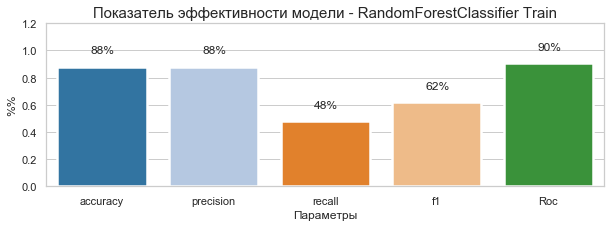

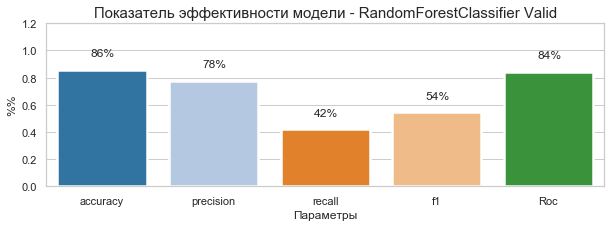

In [40]:
# Выведем графиики для наглядности

def param_bars(base_name, name):
    sns.set(style="whitegrid")
    plt.figure(figsize = (10,3)) 
    df = base_name
    sns.barplot(data=df, palette="tab20", linewidth=2.5)
    plt.title("Показатель эффективности модели - " + str(name), fontsize=15)
    plt.ylabel("%%")
    plt.xlabel("Параметры")
    plt.ylim((0, 1.2)) 
    c = 0
    for i in df.columns:
        plt.text( c - 0.1 , df[i].mean() + 0.1, "{0:.0%}".format(df[i].mean()))
        c = c + 1
    plt.show()

param_bars(info_RFC_train,'RandomForestClassifier Train')
param_bars(info_RFC_valid,'RandomForestClassifier Valid')

<div class="alert alert-block alert-success">
Очень наглядно :)
</div>

<font  color='purple'> !Доработано </font> 

Модель получилась неплохая. Хотя полнота низковата. За счет ее поднятия сможем при балансировке классов улучшить F1.

Оставим пока так. 

**Попробуем другие модели, выберем лучшую и будем уже там бороться с дисбалансом классов.**

<div class="alert alert-block alert-info">
Целевая метрика качества – f1, на нее нужно ориентироваться в первую очередь.
</div>

### Вариант  2 **LogisticRegression**

<font  color='purple'> !Доработано </font> 

In [41]:
parameters = {'random_state':[1234],'C': np.logspace(-4, 4)}

clf = GridSearchCV(LogisticRegression(), param_grid = parameters)

clf.fit(features_train, target_train)

print(clf.best_params_)

{'C': 0.08685113737513521, 'random_state': 1234}


<div class="alert alert-block alert-info">
Параметр C лучше перебирать по логарифмической шкале, например: $10^{-4}, 10^{-3.5}, 10^{-3},\dots 10^4$ (пригодится функция np.logspace(...)). 
</div>

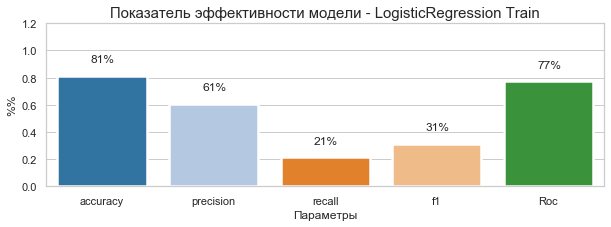

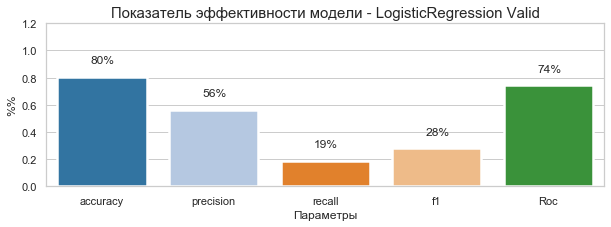

In [42]:
model_LR = LogisticRegression(C=0.08685113737513521, random_state = 1234)

model_LR.fit(features_train, target_train)

info_LR_train = pd.DataFrame()
info_LR_train = put_in_base(info_LR_train, model_LR, features_train, target_train)

info_LR_valid = pd.DataFrame()
info_LR_valid = put_in_base(info_LR_valid, model_LR, features_valid, target_valid)

param_bars(info_LR_train,'LogisticRegression Train')
param_bars(info_LR_valid,'LogisticRegression Valid')

Эта модель дает показатели сильно хуже первой

### Вариант  3 **LinearDiscriminantAnalysis**

In [43]:
parameters = {'solver':[ 'svd', 'lsqr', 'eigen'], 'n_components': [0,1]}

clf = GridSearchCV(LinearDiscriminantAnalysis(), 
                   param_grid = parameters)

clf.fit(features_train, target_train)

print(clf.best_params_)

{'n_components': 0, 'solver': 'svd'}


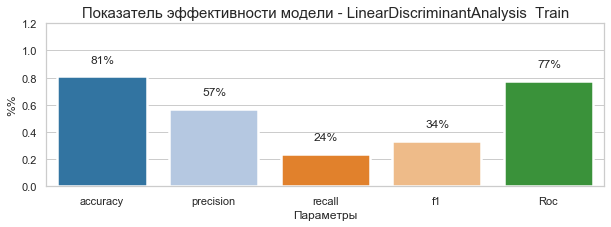

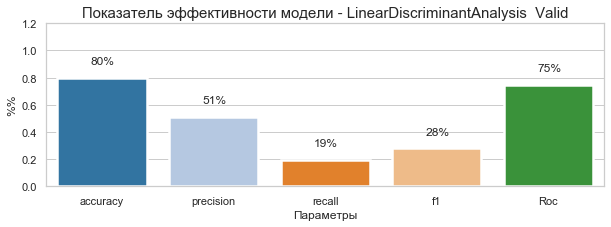

In [44]:
model_LDA = LinearDiscriminantAnalysis(n_components = 0, solver = 'svd' )

model_LDA.fit(features_train, target_train)

info_LDA_train = pd.DataFrame()
info_LDA_train = put_in_base(info_LDA_train, model_LDA, features_train, target_train)

info_LDA_valid = pd.DataFrame()
info_LDA_valid = put_in_base(info_LDA_valid, model_LDA, features_valid, target_valid)

param_bars(info_LDA_train,'LinearDiscriminantAnalysis  Train')
param_bars(info_LDA_valid,'LinearDiscriminantAnalysis  Valid')

Тоже достаточно слабый recall

### Вариант  4 **KNeighborsClassifier**

In [45]:
parameters = {'leaf_size':[i for i in range(1, 5)], 
              'n_neighbors':[i for i in range(5, 15)], 
              'weights':['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

clf = GridSearchCV(KNeighborsClassifier(),  param_grid = parameters)

clf.fit(features_train, target_train)

print(clf.best_params_)

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 11, 'weights': 'distance'}


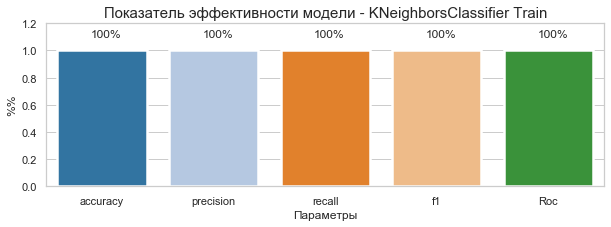

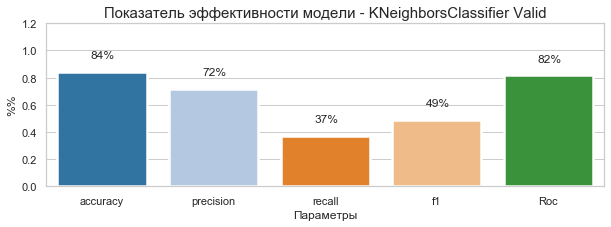

In [46]:
model_KNC = KNeighborsClassifier(leaf_size=1, n_neighbors = 14, weights = 'distance')

model_KNC.fit(features_train, target_train)

info_KNC_train = pd.DataFrame()
info_KNC_train = put_in_base(info_KNC_train, model_KNC, features_train, target_train)

info_KNC_valid = pd.DataFrame()
info_KNC_valid = put_in_base(info_KNC_valid, model_KNC, features_valid, target_valid)

param_bars(info_KNC_train,'KNeighborsClassifier Train')
param_bars(info_KNC_valid,'KNeighborsClassifier Valid')

Похоже модель переобучили.

Хотя на валидационной выборке достаточно неплохой вариант получился. Но Лес пока самый перспективный.

### Вариант  5 **GaussianNB**

In [47]:
model_GNB = GaussianNB( )

print(model_GNB)

GaussianNB(priors=None, var_smoothing=1e-09)


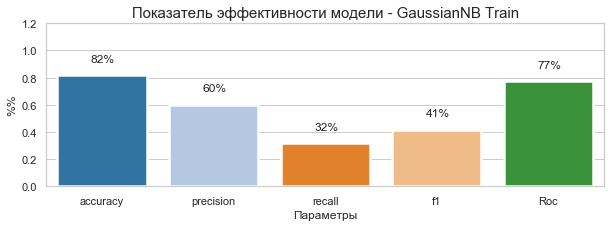

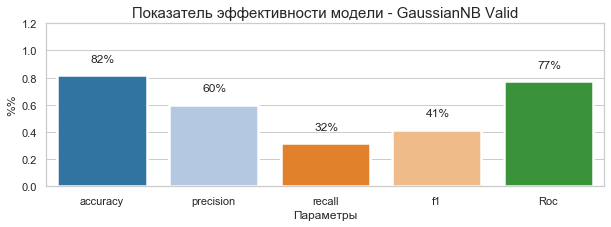

In [48]:
model_GNB = GaussianNB( )

model_GNB.fit(features_train, target_train)


info_GNB_train = pd.DataFrame()
info_GNB_train = put_in_base(info_GNB_train, model_GNB, features_train, target_train)

info_GNB_valid = pd.DataFrame()
info_GNB_valid = put_in_base(info_GNB_train, model_GNB, features_valid, target_valid)

param_bars(info_GNB_train,'GaussianNB Train')
param_bars(info_GNB_valid,'GaussianNB Valid')

Эта модель имеет низкую полноту и точность ниже, чем некоторые модели.


#### Вывод:
**Самая перспективная была первая модель - Рендом Форест. Будем работать с ней, попробуем улучшить глубину**



<div class="alert alert-block alert-success">
Молодец, что рассмотрела много разных моделей. Ок, остановимся на модели RandomForest.
</div>

<a name="3."></a><br/>
<font size="6"><b>3. Борьба с дисбалансом</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

### Улучшите качество модели, учитывая дисбаланс классов. 

* Класса 1 у нас мало. Попробуем сделать буст и увеличить выборку с позитивным признаком.

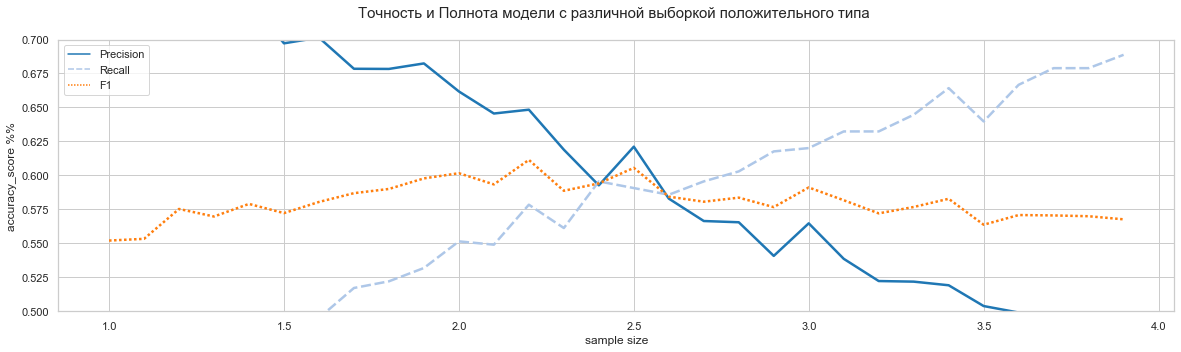

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones.sample(n =(int(len(features_ones)*repeat)), 
                                                                            random_state = 1234, replace=True)])
    target_upsampled = pd.concat([target_zeros] + [target_ones.sample(n =(int(len(features_ones)*repeat)), 
                                                                      random_state = 1234, replace=True)])
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

#<font  color='purple'> !Доработано </font> 

#Посмотрим, насколько именно увеличение выборки даст нам оптимальный F1

model_RFC_upsampled = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)

base_up = pd.DataFrame()
for i in np.arange(1, 4, 0.1):
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
    model_RFC_upsampled.fit(features_upsampled, target_upsampled)
    base_up.loc[i,'Precision'] = precision_score(target_valid, model_RFC_upsampled.predict(features_valid))
    base_up.loc[i,'Recall'] = recall_score(target_valid, model_RFC_upsampled.predict(features_valid))
    base_up.loc[i,'F1'] = f1_score(target_valid, model_RFC_upsampled.predict(features_valid))

    
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (20,5)) 
sns.lineplot(data=base_up, palette="tab20", linewidth=2.5)
plt.title("Точность и Полнота модели с различной выборкой положительного типа \n", fontsize=15)
plt.ylabel("accuracy_score %%")
plt.xlabel("sample size")
plt.ylim((0.5, 0.7)) 
plt.show()

Методом подбора установили, что наиболее удачно увеличение кейсов в 2.2 раза. <br>Т.к. берем кейсы семплингом, чтобы зафиксировать результат указали конкретный рендом стейт.

In [51]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2.2)

<div class="alert alert-block alert-danger">
Upsampling нужен, чтобы число объектов разных классов в выборке примерно сравнялось. Каким следует задать значение repeat?
</div>

<div class="alert alert-block alert-info">
Если хочется взять другое значение, то нужно подтвердить экспериментами, что оно работает лучше.
</div>

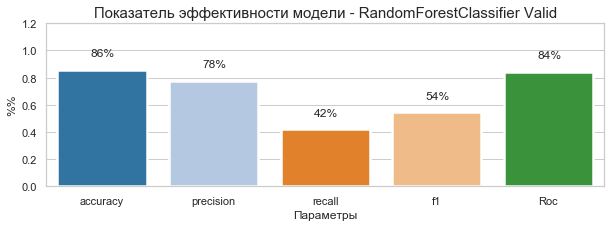

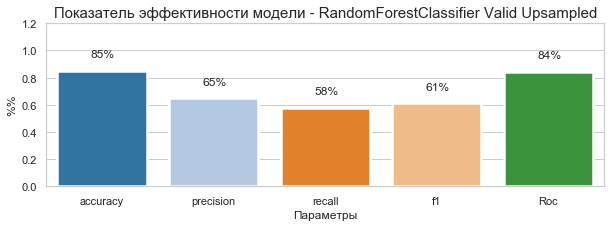

In [52]:
upsampled_model = pd.DataFrame()

model_RFC_upsampled.fit(features_upsampled, target_upsampled)

upsampled_model = put_in_base(upsampled_model, model_RFC_upsampled, features_valid, target_valid)

param_bars(info_RFC_valid,'RandomForestClassifier Valid')

param_bars(upsampled_model,'RandomForestClassifier Valid Upsampled')

<font  color='purple'> !Доработано </font> 

**Апсемплинг в 2.2 раза сильно помог с recall, что позволило оптимизировать F1!**

<div class="alert alert-block alert-info">
В первую очередь, следи за целевой метрикой. В условии есть требование на ее минимальное значение.
</div>

Попробуем наоборот убрать кейсы из категории 0. Чтобы скорректировать дисбаланс

In [53]:
def downsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(n =(int(len(features_zeros)*repeat)), 
                                                            replace=False)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(n =(int(len(target_zeros)*repeat)),
                                                        replace=False)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled


<font  color='purple'> !Доработано </font> 

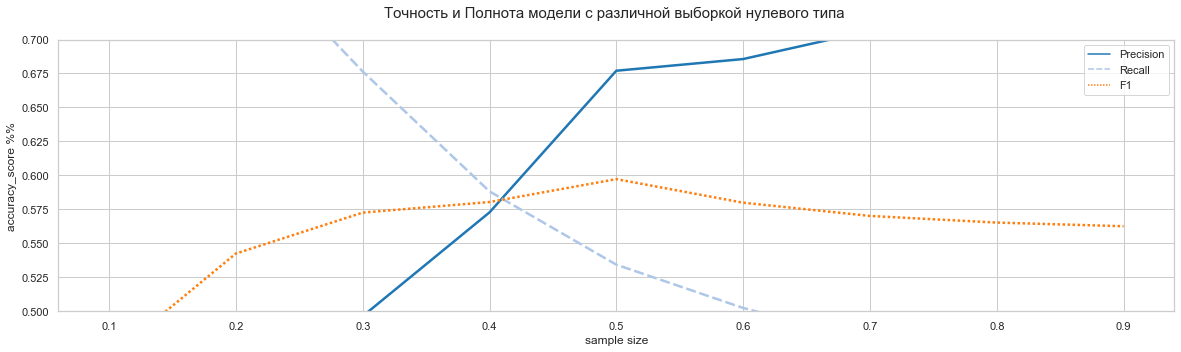

In [54]:
model_RFC_downsampled = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)

base_down = pd.DataFrame()
for i in np.arange(0.1, 1, 0.1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, i)
    model_RFC_downsampled.fit(features_downsampled, target_downsampled)
    base_down.loc[i,'Precision'] = precision_score(target_valid, model_RFC_downsampled.predict(features_valid))
    base_down.loc[i,'Recall'] = recall_score(target_valid, model_RFC_downsampled.predict(features_valid))
    base_down.loc[i,'F1'] = f1_score(target_valid, model_RFC_downsampled.predict(features_valid))

    
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (20,5)) 
sns.lineplot(data=base_down, palette="tab20", linewidth=2.5)
plt.title("Точность и Полнота модели с различной выборкой нулевого типа \n", fontsize=15)
plt.ylabel("accuracy_score %%")
plt.xlabel("sample size")
plt.ylim((0.5, 0.7)) 
plt.show()

Тут нам повторяющиеся кейсы не нужны. При семплинге указали replace=False.
<br> 

Уменьшим выборку так, чтобы 0 занимал меньше от обычных кейсов. Методом подбора выяснили, что лучше всего F1, если используем 0.4 от обычной выборки.<br> 

In [55]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

<div class="alert alert-block alert-danger">
Каким следует задать repeat при проведении downsampling, чтобы классы примерно сравнялись?
</div>

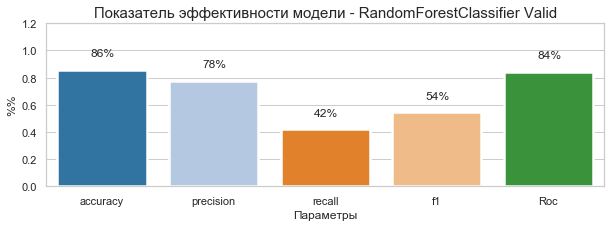

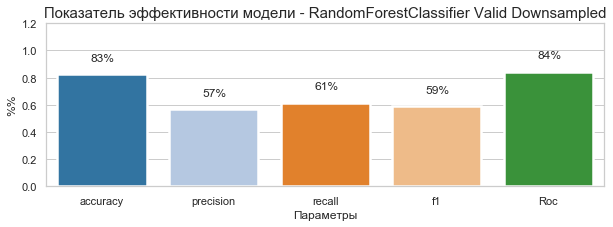

In [56]:
downsampled_model = pd.DataFrame()

model_RFC_downsampled.fit(features_downsampled, target_downsampled)

downsampled_model = put_in_base(downsampled_model, model_RFC_downsampled, features_valid, target_valid)

param_bars(info_RFC_valid,'RandomForestClassifier Valid')

param_bars(downsampled_model,'RandomForestClassifier Valid Downsampled')

Даунсемплинг также хорошо сработал в нашем случае. 

Попробуем ничего не изобретать и просто применить class_weight = balanced

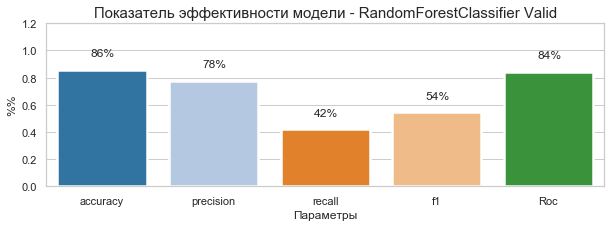

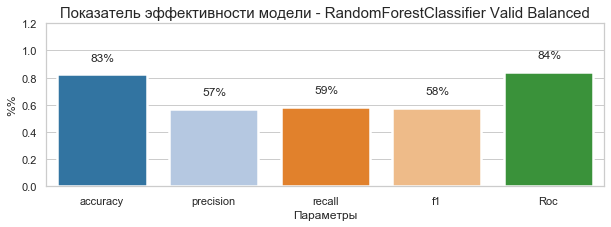

In [57]:
balanced_model = pd.DataFrame()

model_RFC_balanced = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234 ,
                                            class_weight = 'balanced')
model_RFC_balanced.fit(features_test, target_test)

balanced_model = put_in_base(balanced_model, model_RFC_balanced, features_valid, target_valid)


param_bars(info_RFC_valid,'RandomForestClassifier Valid')

param_bars(balanced_model,'RandomForestClassifier Valid Balanced')

Ручная подгонка была чуть более полезна для наших нужд увеличения F1

**В работу возьмем апсемпплинг.**

**Попробуем еще раз посмотреть на параметры. Для этого посмотрим feature_importances, чтобы возможно исключить ненужные.**

<div class="alert alert-block alert-success">
Да, upsampling показал лучшие результаты.
</div>

In [58]:
feature_importances = pd.DataFrame(data = model_RFC_upsampled.feature_importances_,
                                   index = features_train.columns).sort_values(by= 0, ascending=False)

print(feature_importances)

                           0
Age                     0.40
NumOfProducts           0.28
Balance                 0.09
IsActiveMember          0.07
Geography_Germany       0.06
CreditScore             0.03
EstimatedSalary         0.03
Tenure                  0.02
Gender_Male             0.01
Geography_Spain         0.01
HasCrCard               0.00


<div class="alert alert-block alert-success">
Да, интересно посмотреть на важность признаков.
</div>

 <font  color='purple'> !Доработано </font> 

HasCrCard не приносит практически ничего в модель. Уберем его

In [59]:
print(feature_importances.tail(1))

                   0
HasCrCard       0.00


In [60]:
features_train_upsampled_less = features_upsampled.drop(['HasCrCard'], axis=1)
features_valid_less = features_valid.drop(['HasCrCard'], axis=1)
features_test_less = features_test.drop(['HasCrCard'], axis=1)

In [61]:
model_RFC_less = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)
model_RFC_less.fit(features_train_upsampled_less, target_upsampled)

less_model = pd.DataFrame()
model_RFC_less = put_in_base(less_model, model_RFC_less, features_valid_less, target_valid)

print(model_RFC_less)

                         accuracy  precision     recall         f1        Roc
RandomForestClassifier       0.85       0.64       0.58       0.61       0.84


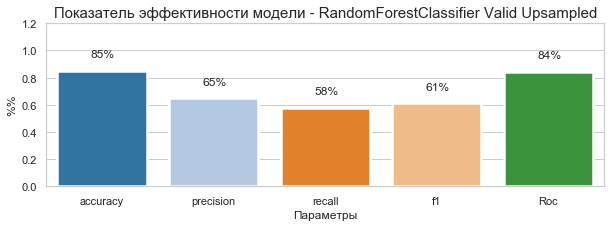

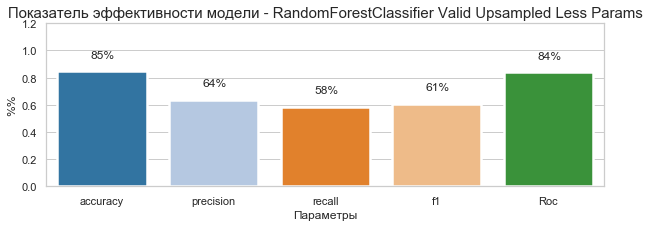

In [62]:
param_bars(upsampled_model,'RandomForestClassifier Valid Upsampled')

param_bars(model_RFC_less,'RandomForestClassifier Valid Upsampled Less Params')

Модель такая же по эффективности, просто чуть "легче" за счет сокращения параметров. 

<div class="alert alert-block alert-info">
F1-мера немного уменьшилась.
</div>

In [63]:
#Финализируем модель

final_model_RFC = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 4, random_state = 1234)
final_model_RFC.fit(features_train_upsampled_less, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

**Вывод:**

* Взяли модель на основе Random Forest Classifier и для сокращения дисбаланса сделали Апсемплинг положительного класса.
* "Облегчили" модель за счет сокращения переменных. Не берем в расчет параметр практически влияющий на модель.


<div class="alert alert-block alert-success">
Отлично, лучшую модель выбрали.
</div>

<a name="4."></a><br/>
<font size="6"><b>4. Тестирование модели</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)



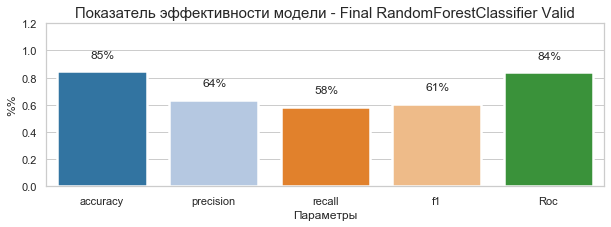

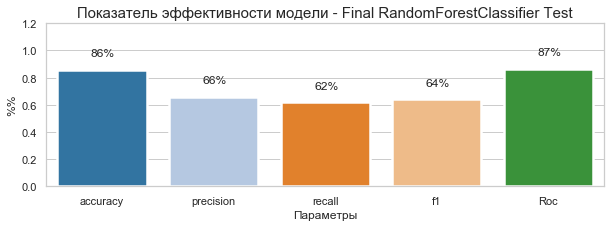

In [64]:
info_final_valid = pd.DataFrame()
info_final_valid = put_in_base(info_final_valid, final_model_RFC, features_valid_less, target_valid)

info_final_test = pd.DataFrame()
info_final_test = put_in_base(info_final_test, final_model_RFC, features_test_less, target_test)

param_bars(info_final_valid,'Final RandomForestClassifier Valid')
param_bars(info_final_test,'Final RandomForestClassifier Test')

#### Выводы:

Точность модели на тестовой выборке - 86%, F1 - 64%.  Что достаточно в соответствии с ТЗ.

<div class="alert alert-block alert-success">
Ок, требуемое качество достигнуто.
</div>



<a name="5."></a><br/>
<font size="6"><b>5. Проверка модели на адекватность</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)



* Проверим модель на адекватнось глазами. Посмотрим на доли Exited. 

In [65]:
print(bold(),"% Exited in test sample: target",colored(round(target_test.mean(),2),'blue')+bold(),"VS predictions",
      colored(round(final_model_RFC.predict(features_test_less).mean() ,2),'blue'),bold_end())

 % Exited in test sample: target 0.2 VS predictions 0.19 


Хороший уровнь доли Exited. 

* Проверим что наша модель эффективна. А имеено точность значимо выше дамми модели.

<font  color='purple'> !Доработано </font> 

/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/Users/lesia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



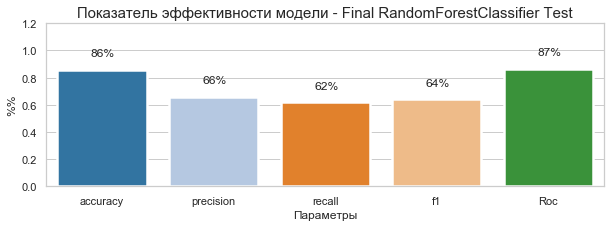

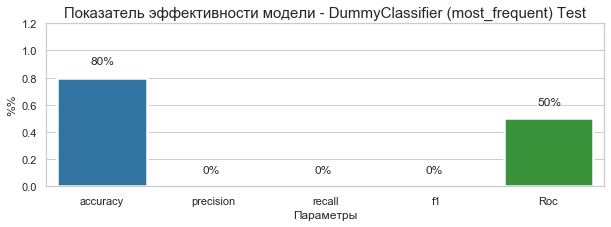

In [66]:
#Сравним
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train_upsampled_less, target_upsampled)

dummy_clf_test = pd.DataFrame()
dummy_clf_test = put_in_base(dummy_clf_test, dummy_clf, features_test_less, target_test)

param_bars(info_final_test,'Final RandomForestClassifier Test')
param_bars(dummy_clf_test,'DummyClassifier (most_frequent) Test')

DummyClassifier не имеет метрик точности и полноты для расчета F1.
<br> 
<br> ROC score финальной модели значительно лучше, чем у дамми.
<br> Однако аccuracy дамми и финальной модели различаются всего на 6%

<div class="alert alert-block alert-info">
Чему равны другие меры качества?
</div>

Значимо ли различие аccuracy?

In [67]:
#Сделаем столбцы
model = target_test == final_model_RFC.predict(features_test_less)
dummy = target_test == dummy_clf.predict(features_test_less)

<div class="alert alert-block alert-info">
Стоило сформулировать нулевую и альтернативную гипотезы.
</div>

Нулевая гипотеза состоит в том, что средний уровень точности для данных моделей значимо не различается.

In [68]:
alpha = .01 

results = st.ttest_ind(model, dummy)

print('p-значение:', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, значит средняя доля точности скорее всего различается.")
else:
    print("Не получилось отвергнуть нулевую гипотезу, и не знаем различается ли или нет ")

p-значение: 3.2812311768242536e-07
Отвергаем нулевую гипотезу, значит средняя доля точности скорее всего различается.


<div class="alert alert-block alert-success">
Проверка гипотезы выполнена корректно.
</div>

<div class="alert alert-block alert-info">

Только С помощью стат. тестов мы не можем **подтвердить** никакую гипотезу. Поэтому **утверждать**, что «точность различается» некорректно. Можно только сказать, что имеющиеся данные дают основания отвергнуть нулевую гипотезу. **Скорее всего**, точности моделей различаются.
</div>

Ура! Мы сделали модель, которая скорее всего точнее dummy

<div class="alert alert-block alert-success">
Здорово, что проверила модель на адекватность.
</div>

* Проверим зависимость от объема выборки

<font  color='purple'> !Доработано </font> 

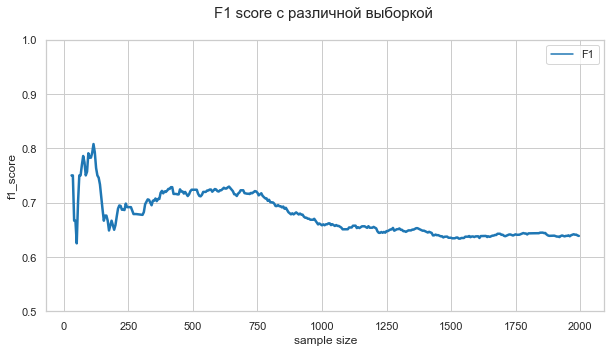

In [69]:
#делаем базу. добавляем по 5 кейсов увеличивая семпл
base_min = pd.DataFrame()
for i in range(30,len(features_test_less),5):
    predictions_test = final_model_RFC.predict(features_test_less)
    base_min.loc[i,'F1'] = f1_score(target_test[0:i], predictions_test[0:i])

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.lineplot(data=base_min, palette="tab20", linewidth=2.5)
plt.title("F1 score с различной выборкой \n", fontsize=15)
plt.ylabel("f1_score")
plt.xlabel("sample size")
plt.ylim((0.5, 1.0)) 
plt.show()

Модель не очень стабильна на небольшой выборке, что ожидаемо. 
Так как классы в дисбалансе и у нас мало класса 1, модель дает избыточный F1 на средних выборках(за чет обилия кейсов с классом 0).
<br>В целом показатель точности не сильно колеблется и далее стабилизируется.

<div class="alert alert-block alert-info">
Интересное исследование. Почему бы не следить за целевой метрикой качества F1?
</div>

* Посмотрим на ROC кривую для спокойствия. (Хотя так как мы знаем, что ROC скорр 0.87, поэтому кривая не должна быть сильно смещена)

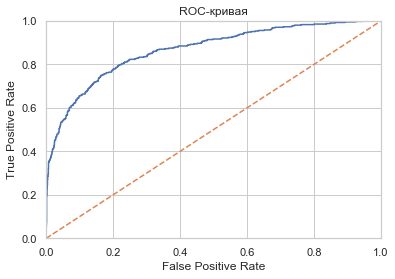

In [70]:
probabilities_test = final_model_RFC.predict_proba(features_test_less)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1])

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

В целом неплохо. Однако видно, что модель чуть перекошена и ей проще предсказывать 0 класс.


#### Вывод:

Модель можно считать адекватной. 

* Соответствует ТЗ по параметру F1 - 0.63.

* Предсказанная доля положительного класса сильно не отличается от таргет

* Она точнее дамми модели определяет точность 

* Высокий показатель ROC - 0.87


#### Экспортируем модель 

In [71]:
# сохраняем модель для дальнейшей работы вне книги
joblib.dump(final_model_RFC, 'model_RFC_churn_accuracy_86_f1_64.joblib')

['model_RFC_churn_accuracy_86_f1_64.joblib']


<a name="6."></a><br/>
<font size="6"><b>Вывод</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)



**На основе данных о текущих и ушедших клиентах Бета-Банка, была построена модель для задачи классификации оттока клиентов, которая прогнозирует уйдёт ли клиент из банка в ближайшее время или нет.**

**Необходимо построить модель, со значением F1-меры от 0.59 и более. Наша модель на тестовой выборке имеет F1-меру 0.64.**

При обучении модели потребовалась ручная ребалансировка классов. В тренировочной выборке положительный класс был увеличен в 2.2 раза.


**Модель построена на основе информации о поведении клиентов на основе данных:**
    
* Age - возраст                    
* NumOfProducts - NumOfProducts   
* Balance - баланс на счёте      
* IsActiveMember - активность клиента     
* Geography_Germany* -  страна проживания Германия    
* CreditScore - кредитный рейтинг   
* EstimatedSalary - предполагаемая зарплата    


**переменная преобразована(0 - если не проживает в Германии,1 - если проживает)*

*В рамках подготовки данных произведен модели проведено масштабирование количественных признаков 
('CreditScore','Age','Balance','EstimatedSalary') с помощью StandardScaler*


**Классификация производится с помощью "Random Forest Classifier", c параметрами :**
* n_estimators - 50 
* max_depth - 7
* max_features = 4
* random_state = 1234



**Вы можете скачать модель с названием <font color='blue'>  model_RFC_churn_accuracy_86_f1_64.joblib
</font>**

**Кодирование результатов:**
<font color='blue'> 
* **0 - НЕ выявлено, что клиент уйдет из банка в ближайшее время**
* **1 - Клиент уйдет из банка в ближайшее время**

<div class="alert alert-block alert-warning">
<b>Итоговый комментарий:</b> 

Спасибо, ты провела великолепное исследование, осталось его немного доработать. Отдельное спасибо за прекрасное оформление работы!

</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*